In [42]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# Койка

In [25]:

file_path = 'data.xlsx'
data = pd.read_excel(file_path)

In [26]:
data.head()

,Дата,SBER_CLOSE,USD_RUB
0,2023-01-03,141.78,71.1375
1,2023-01-04,141.43,72.0000
2,2023-01-05,141.27,72.1800
3,2023-01-06,141.40,72.1225
4,2023-01-09,142.40,69.9900


In [27]:
clean_data = data[['Дата', 'SBER_CLOSE', 'USD_RUB']]
clean_data['SBER_CLOSE_diff'] = clean_data['SBER_CLOSE'].diff()
clean_data['USD_RUB_diff'] = clean_data['USD_RUB'].diff()
clean_data = clean_data.dropna()


In [29]:
X = clean_data['USD_RUB_diff']  
y = clean_data['SBER_CLOSE_diff']  
X = sm.add_constant(X)

In [30]:
model = sm.OLS(y, X).fit()

In [31]:
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:        SBER_CLOSE_diff   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4788
Date:                Sat, 06 Apr 2024   Prob (F-statistic):              0.490
Time:                        09:27:29   Log-Likelihood:                -793.03
No. Observations:                 304   AIC:                             1590.
Df Residuals:                     302   BIC:                             1598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5025      0.190      2.645   

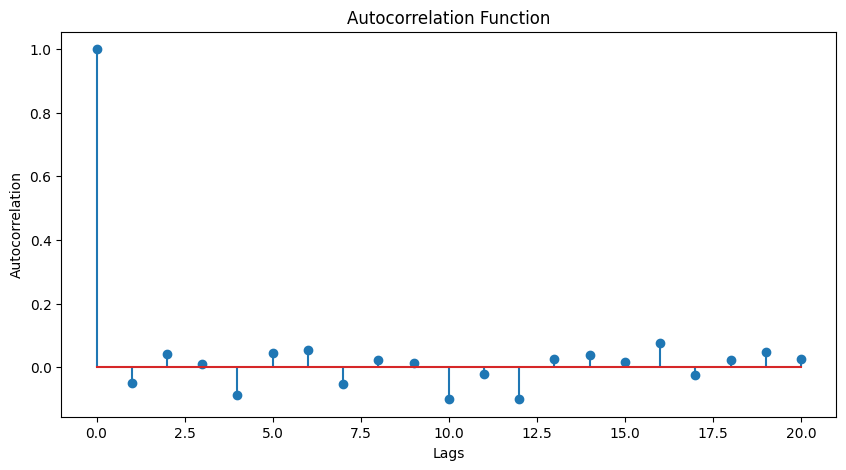

In [34]:
lag_acf = acf(clean_data['SBER_CLOSE_diff'], nlags=20)
plt.figure(figsize=(10, 5))
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('Autocorrelation Function')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [35]:
model_ar = AutoReg(clean_data['SBER_CLOSE_diff'], lags=1).fit()

model_ar_summary = model_ar.summary()
model_ar_summary

c:\Users\sedof\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:        SBER_CLOSE_diff   No. Observations:                  304
Model:                     AutoReg(1)   Log Likelihood                -790.734
Method:               Conditional MLE   S.D. of innovations              3.290
Date:                Sat, 06 Apr 2024   AIC                           1587.469
Time:                        09:40:42   BIC                           1598.610
Sample:                             1   HQIC                          1591.926
                                  304                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5437      0.191      2.843      0.004       0.169       0.918
SBER_CLOSE_diff.L1    -0.0511      0.057     -0.889      0.374      -0.164       0.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -19.5862           +0.0000j           19.5862            0.5000
-----------------------------------------------------------------------------
"""

# Н-Тест

In [37]:
bg_test = acorr_breusch_godfrey(model_ar, nlags=1)  

bg_test

(0.0009041842246962917,
 0.976011500618199,
 0.0008982186923778728,
 0.9761106040000729)

In [38]:
print("Результаты H-теста Бреуша-Годфри (тест на автокорреляцию остатков):")
print(f"LM-статистика: {bg_test[0]:.4f}")
print(f"p-значение LM-статистики: {bg_test[1]:.4f}")
print(f"F-статистика: {bg_test[2]:.4f}")
print(f"p-значение F-статистики: {bg_test[3]:.4f}")

if bg_test[1] < 0.05:
    print("Вывод: Есть основания отвергнуть нулевую гипотезу о отсутствии автокорреляции остатков.")
else:
    print("Вывод: Нет оснований отвергать нулевую гипотезу о отсутствии автокорреляции остатков.")


Результаты H-теста Бреуша-Годфри (тест на автокорреляцию остатков):
LM-статистика: 0.0009
p-значение LM-статистики: 0.9760
F-статистика: 0.0009
p-значение F-статистики: 0.9761
Вывод: Нет оснований отвергать нулевую гипотезу о отсутствии автокорреляции остатков.


# Адаптивные ожидания

In [39]:
alpha = 0.5 
expected_values = [clean_data['SBER_CLOSE'].iloc[0]] 

for actual in clean_data['SBER_CLOSE'].iloc[1:]:
    next_expected = expected_values[-1] + alpha * (actual - expected_values[-1])
    expected_values.append(next_expected)

clean_data['Expected_SBER_CLOSE'] = expected_values


print(clean_data[['Дата', 'SBER_CLOSE', 'Expected_SBER_CLOSE']].head())


        Дата  SBER_CLOSE  Expected_SBER_CLOSE
1 2023-01-04      141.43            141.43000
2 2023-01-05      141.27            141.35000
3 2023-01-06      141.40            141.37500
4 2023-01-09      142.40            141.88750
5 2023-01-10      142.81            142.34875


# Корректировка модели

In [40]:
alpha_new = 0.3  # Новый коэффициент адаптации
expected_values_new = [clean_data['SBER_CLOSE'].iloc[0]]  # Переопределение начального ожидания

# Вычисление новых ожидаемых значений с новым коэффициентом
for actual in clean_data['SBER_CLOSE'].iloc[1:]:
    next_expected = expected_values_new[-1] + alpha_new * (actual - expected_values_new[-1])
    expected_values_new.append(next_expected)

# Сохранение результатов в DataFrame
clean_data['Expected_SBER_CLOSE_new'] = expected_values_new

# Вывод первых нескольких строк для сравнения старых и новых ожидаемых значений
clean_data[['Дата', 'SBER_CLOSE', 'Expected_SBER_CLOSE', 'Expected_SBER_CLOSE_new']].head()

,Дата,SBER_CLOSE,Expected_SBER_CLOSE,Expected_SBER_CLOSE_new
1,2023-01-04,141.43,141.43000,141.430000
2,2023-01-05,141.27,141.35000,141.382000
3,2023-01-06,141.40,141.37500,141.387400
4,2023-01-09,142.40,141.88750,141.691180
5,2023-01-10,142.81,142.34875,142.026826


In [43]:


# Добавление лагов в данные
clean_data['lag1'] = clean_data['SBER_CLOSE'].shift(1)
clean_data['lag2'] = clean_data['SBER_CLOSE'].shift(2)

# Удаление строк с NaN значениями, которые появляются из-за сдвига
clean_data.dropna(inplace=True)

# Создание полиномиальных признаков для лагов
X = clean_data[['lag1', 'lag2']]
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Зависимая переменная
y = clean_data['SBER_CLOSE']

# Построение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly, y)

# Вывод коэффициентов модели
model_coefs = model.coef_
model_intercept = model.intercept_
model_coefs, model_intercept

(array([ 1.39959383, -0.3751649 ,  0.00611505, -0.01429619,  0.0081056 ]),
 -0.8927037414408119)